### Image reconstructions with deep learning 

In this notebook one can see what kind of results three different deep neural networks algorithms give when trained to reconstruct images. <br>
The three algorithms are FBP with U-Net denoising, Learned Gradient Scheme (LGS) and Learned Primal-Dual (LPD).

In [14]:
import cv2 as cv
import torch
import odl
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from odl.contrib.torch import OperatorModule
from FBP_UNet_module import UNet
from LGS_module import LGS
from LPD_module import LPD

Next one needs to get image(s) which to use ODL to get sinograms and add noise to them. <br>
There is alot of ways to get images but here is one, feel free to change the next part if you know some better way. <br>
Just be careful to not change images' data type or anything if not sure it will work. <br>
The function below either gives you all the images from the directory or just $n$ amount of random images. <br>
#### Images are scaled for a reason that the training would go quicker.

In [15]:
def get_images(path, amount_of_images='all', scale_number=1):

    all_images = []
    all_image_names = os.listdir(path)
    print(len(all_image_names))
    if amount_of_images == 'all':
        for name in all_image_names:
            temp_image = cv.imread(path + '/' + name, cv.IMREAD_UNCHANGED)
            image = temp_image[90:410, 90:410]
            image = image[0:320:scale_number, 0:320:scale_number]
            image = image / 0.07584485627272729
            all_images.append(image)
    else:
        temp_indexing = np.random.permutation(len(all_image_names))[:amount_of_images]
        
        images_to_take = [all_image_names[i] for i in temp_indexing]
        for name in images_to_take:
            temp_image = cv.imread(path + '/' + name, cv.IMREAD_UNCHANGED)
            image = temp_image[90:410, 90:410]
            image = image[0:320:scale_number, 0:320:scale_number]
            image = image / 0.07584485627272729
            all_images.append(image)
    
    return all_images

Next up is to define the function for ODL geometry and Ray transform. It is the same as in classical algorithms.

In [16]:
def geometry_and_ray_trafo(setup='full', min_domain_corner=[-1,-1], max_domain_corner=[1,1], \
                           shape=(100,100), source_radius=2, detector_radius=1, \
                           dtype='float32', device='cpu', factor_lines = 1):

    device = 'astra_' + device
    print(device)
    domain = odl.uniform_discr(min_domain_corner, max_domain_corner, shape, dtype=dtype)

    if setup == 'full':
        angles = odl.uniform_partition(0, 2*np.pi, 360)
        lines = odl.uniform_partition(-1*np.pi, np.pi, int(1028/factor_lines))
        geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
        output_shape = (360, int(1028/factor_lines))
    elif setup == 'sparse':
        angle_measurements = 100
        line_measurements = int(512/factor_lines)
        angles = odl.uniform_partition(0, 2*np.pi, angle_measurements)
        lines = odl.uniform_partition(-1*np.pi, np.pi, line_measurements)
        geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
        output_shape = (angle_measurements, line_measurements)
    elif setup == 'limited':
        starting_angle = 0
        final_angle = np.pi * 3/4
        angles = odl.uniform_partition(starting_angle, final_angle, 360)
        lines = odl.uniform_partition(-1*np.pi, np.pi, int(512/factor_lines))
        geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
        output_shape = (int(360), int(512/factor_lines))
        
    # domain = odl.uniform_discr(min_domain_corner, max_domain_corner, output_shape, dtype=dtype)

    ray_transform = odl.tomo.RayTransform(domain, geometry, impl=device)

    return domain, geometry, ray_transform, output_shape


Then there is couple of parameters and such. <br>
For a device it is good to use CUDA if available. Not necessary when not training but still.

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
path = r'.'
amount_of_images = 2
mean = 0
noise_percentage = 0.05


loss_test = nn.MSELoss()

def psnr(loss):
    
    psnr = 10 * np.log10(1.0 / loss+1e-10)
    
    return psnr


Next one imports the image(s) and does some tricks with the data to get everything to roll. Also ODL operators are defined here.

In [18]:
images = get_images(r'walnuts', amount_of_images, scale_number=2)
images = np.array(images, dtype='float32')
images = torch.from_numpy(images).float().to(device)

shape = (np.shape(images)[1], np.shape(images)[2])
domain, geometry, ray_transform, output_shape = geometry_and_ray_trafo(setup='full', shape=shape, device=device, factor_lines = 2)
fbp_operator = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_transform, padding=1)

### Using odl functions to make odl operators into PyTorch modules
ray_transform_module = OperatorModule(ray_transform).to(device)
adjoint_operator_module = OperatorModule(ray_transform.adjoint).to(device)
fbp_operator_module = OperatorModule(fbp_operator).to(device)

### Making sinograms from the images using Radon transform module
sinograms = ray_transform_module(images) #.cpu().detach().numpy()

### Allocating used tensors
noisy_sinograms = torch.zeros((sinograms.shape[0], ) + output_shape).cpu().detach().numpy()
rec_images = torch.zeros((sinograms.shape[0], ) + shape)

### Adding Gaussian noise to the sinograms.
for k in range(amount_of_images):
    sinogram_k = sinograms[k,:,:].cpu().detach().numpy()
    noise = np.random.normal(mean, sinogram_k.std(), sinogram_k.shape) * noise_percentage
    noisy_sinograms[k,:,:] = sinogram_k + noise

noisy_sinograms = np.array(noisy_sinograms, dtype='float32')
noisy_sinograms = torch.from_numpy(noisy_sinograms).float().to(device)

rec_images = fbp_operator_module(noisy_sinograms)
rec_images = rec_images[:,None,:,:]

38
astra_cpu


### FBP + U-Net denoising <br>
Here one loads and uses the U-Net denoising algorithm.

5.68e-04
PSNR = 32.46 dB


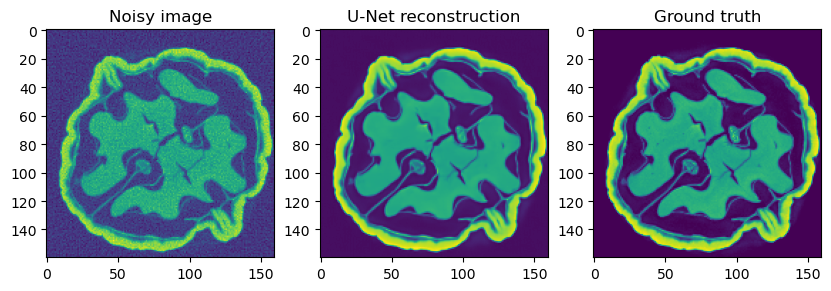

In [19]:
UNet = UNet(in_channels=1, out_channels=1).to(device)
UNet.load_state_dict(torch.load(path+'/UNet1_005.pth', map_location=device))

UNet.eval()

UNet_reco = UNet(rec_images)

MSE = loss_test(images[0,:,:], UNet_reco[0,0,:,:]).cpu().detach().numpy()
print(f'{MSE:.2e}')
print(f'PSNR = {psnr(MSE):.2f} dB')

plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,3,1)
plt.imshow(rec_images[0,0,:,:].cpu().detach().numpy())
plt.gca().set_title('Noisy image')
plt.subplot(1,3,2)
plt.imshow(UNet_reco[0,0,:,:].cpu().detach().numpy())
plt.gca().set_title('U-Net reconstruction')
plt.subplot(1,3,3)
plt.imshow(images[0,:,:].cpu().detach().numpy())
plt.gca().set_title('Ground truth')
plt.show()

### LGS <br>
Then is the LGS. Better result than with the U-Net.

3.40e-04
PSNR = 34.69 dB


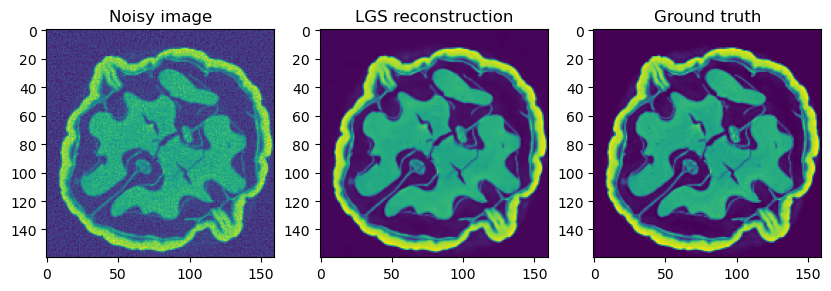

In [20]:
# sinograms = torch.from_numpy(sinograms).float().to(device)
sinograms = sinograms[:,None,:,:]
noisy_sinograms = noisy_sinograms[:,None,:,:]
# print(rec_images.shape)
# print(sinograms.shape)

LGS = LGS(adjoint_operator_module, ray_transform_module, \
          noisy_sinograms, rec_images, in_channels=2, out_channels=1, step_length=0.1, n_iter=5).to(device)
LGS.load_state_dict(torch.load(path+'/LGS1_005.pth', map_location=device))

LGS.eval()

LGS_reco, _ = LGS(rec_images[:,:,:], noisy_sinograms[:,:,:])

MSE = loss_test(images[0,:,:], LGS_reco[0,0,:,:]).cpu().detach().numpy()
print(f'{MSE:.2e}')
print(f'PSNR = {psnr(MSE):.2f} dB')

# print('reco', type(reco))

plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,3,1)
plt.imshow(rec_images[0,0,:,:].cpu().detach().numpy())
plt.gca().set_title('Noisy image')
plt.subplot(1,3,2)
plt.imshow(LGS_reco[0,0,:,:].cpu().detach().numpy())
plt.gca().set_title('LGS reconstruction')
plt.subplot(1,3,3)
plt.imshow(images[0,:,:].cpu().detach().numpy())
plt.gca().set_title('Ground truth')
plt.show()


### LPD <br>
Finally the LPD. LPD did perform a little bit better in training, but when used here sometimes the LGS is better.

3.51e-04
PSNR = 34.55 dB


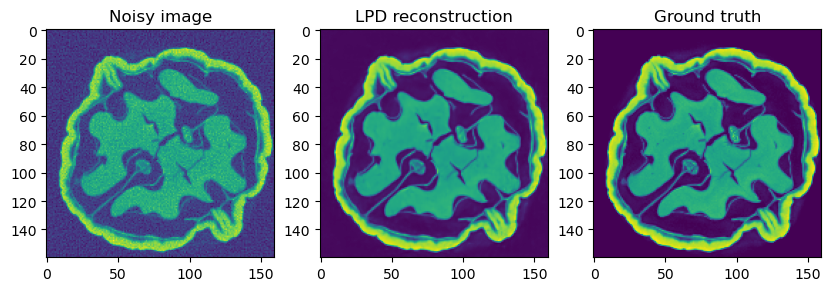

In [21]:
operator_norm = odl.power_method_opnorm(ray_transform)

LPD = LPD(ray_transform_module, adjoint_operator_module, operator_norm, n_iter=10, device=device)
LPD.load_state_dict(torch.load(path+'/LPD1_005.pth', map_location=device))

LPD.eval()

LPD_reco = LPD(rec_images[:,:,:], noisy_sinograms[:,:,:])

MSE = loss_test(images[0,:,:], LPD_reco[0,0,:,:]).cpu().detach().numpy()
print(f'{MSE:.2e}')
print(f'PSNR = {psnr(MSE):.2f} dB')

plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,3,1)
plt.imshow(rec_images[0,0,:,:].cpu().detach().numpy())
plt.gca().set_title('Noisy image')
plt.subplot(1,3,2)
plt.imshow(LPD_reco[0,0,:,:].cpu().detach().numpy())
plt.gca().set_title('LPD reconstruction')
plt.subplot(1,3,3)
plt.imshow(images[0,:,:].cpu().detach().numpy())
plt.gca().set_title('Ground truth')
# plt.colorbar()
plt.show()

Last thing is the comparison of all the reconstructions:

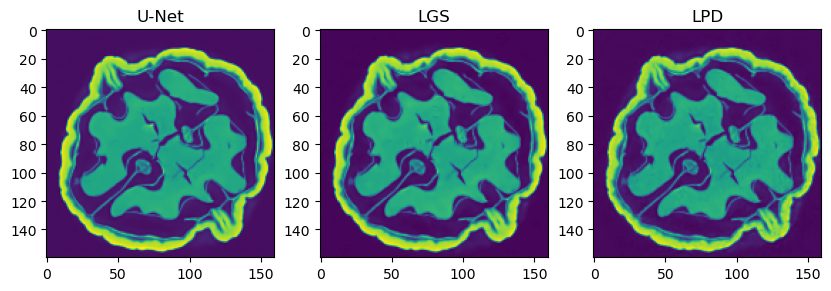

In [22]:
image_number = 1 # Must be less than or equal to amount of images

plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,3,1)
plt.imshow(UNet_reco[image_number-1,0,:,:].cpu().detach().numpy())
plt.gca().set_title('U-Net')
plt.subplot(1,3,2)
plt.imshow(LGS_reco[image_number-1,0,:,:].cpu().detach().numpy())
plt.gca().set_title('LGS')
plt.subplot(1,3,3)
plt.imshow(LPD_reco[image_number-1,0,:,:].cpu().detach().numpy())
plt.gca().set_title('LPD')
# plt.colorbar()
plt.show()